<div style="text-align: center; margin-top: 1cm; margin-bottom: 1cm;">
    <img src="rossman_logo.png" width="200" height="200">
    <hr style="height: 0; border: none; border-top: 1px solid black; width: 378px; transform: scale(0.264583);">
</div>

<center>
    <h1>Rossmann Store Sales - Time Series Analysis and Forecasts</h1>
    <h2>By: Adam Kacprzycki</h2>
    <h2>Part I - EDA </h2>
</center>

<p>Data source: <a href="https://www.kaggle.com/competitions/rossmann-store-sales/data">rossman_commercial_competition</a></p>

# Introduction

The present notebook primarily focuses on the topic of Time Series Analysis and explores multivariate models utilized in this project, such as Random Trees Regression, LGBM and XGBoost.

Following the standard practice of CRISP-DM, the modeling phase was preceded by extensive Exploratory Data Analysis of the key metrics. This analysis unveiled trends and patterns in the data, providing a strong foundation for subsequent causal analysis and identifying factors that could impact the used machine learning models.

# Business understand and Objectives: <a class="anchor" id="chapter1"></a>


Rossmann operates a network of more than 3,000 drug stores across 7 European countries. **One of the challenges faced by Rossmann is the task of predicting daily sales for up to six weeks in advance at each store.** The sales of these stores are influenced by various factors, such as promotions, competition, school and state holidays, seasonality, and locality. Due to the unique circumstances of each store and the individual predictions made by store managers, the accuracy of these predictions can vary significantly.

**Objectives:**

- The primary objective of this project is **to predict the daily sales for a period of six weeks for 1,115 drug stores operated by Rossmann Stores in Germany.** The prediction task aims to provide accurate sales forecasts for each store.
- Evaluation within this project will be based on the Kaggle private score. **The evaluation metric used is the root mean squared percentage error -> [RMSPE](https://stats.stackexchange.com/questions/413249/what-is-the-correct-definition-of-the-root-mean-square-percentage-error-rmspe)**, which will be calculated on approximately 70% of the test dataset. <br>

_____

# Importing libaries

In [1]:
# base tools:
from datetime import datetime as dt
import pandas as pd
from pandas_summary import DataFrameSummary
from pandas_profiling import ProfileReport
import numpy as np
import math
import utils as utl #module with user's custom func

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from cycler import cycler

# statistics
import statsmodels.api as sm

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_____

# Data loading: <a class="anchor" id="chapter2"></a>

__Files:__

- train.csv - historical data including Sales. Shape: 1.017.209 x 8
- store.csv - supplemental information about the stores. Shape: 1115 x 10

In [2]:
df_sales = pd.read_csv('data/train.csv', low_memory = False) #base data to analyse
df_store = pd.read_csv('data/store.csv', low_memory = False) #detailed description of store

## Feature description:

The **train.csv** dataset describes the sales figures for a store on a particular date. The data fields are descibed below:

|ColumnName|Description:|
|---|---|
|Id |an Id that represents a (Store, Date) duple within the test set|
|Store|a unique numerical store identifier (1-1115) - primary key|
|DayOfWeek| the day of week (1-7)|
|Date| the date, ranging from 2013-01-01 to 2015-07-31|
|Sales| the turnover of the specified store on the specified date - **target variable**|
|Customers| the number of customers of the specified store on the specified date|
|Open| indicates whether the store was open (0 = Closed, 1 = Open)|
|Promo|indicates whether the store was running a promotion (0 = No, 1 = Yes)|
|StateHoliday| indicates if it was a state holiday (a = Public Holiday, b = Easter holiday, c = Christmas, 0 = None)|
|SchoolHoliday| indicates if it was a school holiday (0 = No, 1 = Yes)|

**Number of observations: 1 017 209**

The **store.csv** dataset contains additional information about each of the store. The data fields are described belowe:

|ColumnName|Description|
|---|---|
|Store|a unique numerical store identifier (1 - 1,115) - primary key|
|StoreType|differentiates between the 4 different types of stores (a, b, c, d)|
|Assortment| describes the assortment of goods carried by the store (a = Basic, b = Extra, c = Extended)|
|CompetitionDistance| the distance (in metres) to the nearest competitor’s store|
|CompetitionOpenSinceMonth| the month in which the competition opened|
|CompetitionOpenSinceYear| the year in which the competition opened|
|Promo2| indicates if a store is participating in a continuing and consecutive promotion (0 = No, 1 = Yes)|
|Promo2SinceWeek| the week of the year in which the store began participating in Promo2(from 1 - 52, presumably, but some weeks are unrepresented in the data)|
|Promo2SinceYear| the year in which the store began participating in Promo2 (from 2009 - 2015)|
|PromoInterval| describes the consecutive intervals in which Promo2 is activated, giving the months the promotion is renewed (either “Jan, Apr, Jul, Oct”, “Feb, May, Aug, Nov” or “Mar, Jun, Sept, Dec”)|

**Number of observations: 1 115** </br>
*this is number of analyzed stores

___

## Data Inspection:

In this section, a Pandas Profile Report will be utilized to provide a succinct overview of the analyzed datasets. The primary objective of this segment is to:

- investigate fundamental descriptive statistics,
- examine data distributions and identify outliers,
- detect missing data and other values that may cast doubt on their accuracy.

### Datatest: df_sales - summary
The dataset "df_sales" comprises both numerical and categorical data refering to sales in general, as well as events that may potentially affect it.

<table>
<tr><th>Dataset summary: </th><th>Dataset data types:</th></tr>
<tr><td>

| Dataset statistics (used: ProfileReport): | Values |
| --- | --- |
| Number of variables: | 9 |
| Number of observations: |1.017.209|  
| Missing cells [number]: | 0 |
| Missing cells (%) |0 %| 
| Duplicate rows: | 0 |
| Duplicate rows (%): |0 %|_
| Total size in memory: | 69.8 MiB |

</td><td>
    
| Column_name: |data type (used: df_sales.dtypes)| ML data type|
|--- | --- | ---|
|Store|int64|id & primary_key - categorical: nominal|
|DayOfWeek|int64|categorical: nominal|
|Date|object **- need datetime format**| date |
|Sales:|int64| numeric: continous|
|Customers|int64| numeric: discrete|
|Open|int64|categorical: binary|
|Promo |int64|categorical: binary|
|StateHoliday |object|categorical: nominal|
|SchoolHoliday |int64|categorical: nominal|

</td></tr> </table>

In [3]:
#Sample df_sales output:
df_sales.sample(4)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
5561,1102,1,2015-07-27,9328,819,1,1,0,0
44071,587,1,2015-06-22,9068,598,1,0,0,0
523405,141,3,2014-03-19,5736,601,1,1,0,0
488783,84,6,2014-04-19,14517,1634,1,0,0,0


### Pandas Profilling Report - df_sales - summary info.

In this section, the Pandas Profiling Report will be executed to gain preliminary insights into the "df_sales" dataset and provide a concise summary of information pertaining to it.

Please note that while the ProfileReport may provide valuable insights from the dataset, for larger datasets, executing the ProfileReport could be time-consuming or the preparation of it may fail.

In [4]:
#Pandas ProfileReport:
# df_sales_profile = ProfileReport(df_sales)
# df_sales_profile

In [5]:
#free up memory - df_sales_profile 
# del df_sales_profile
# if not 'df_sales_profile' in locals(): print('df_sales_profile is not in locals')

In [6]:
#df_sales data types:
pd.DataFrame(df_sales.dtypes, columns=['data_type']).T

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
data_type,int64,int64,object,int64,int64,int64,int64,object,int64


### **Preliminary observations to take into account concerned 'df_sales'**

Upon analyzing the sales dataset, the following were observed:

- The dataset contains 1,017,209 observations and 9 features.
- Several data types in the columns should be changed to another, particularly 'Date' -> `pd.to_datetime`.
- Categorical features need to be encoded before model training.
- **There are no missing or duplicated values that need to be addressed.**
- Memory usage could be optimized using `df.astype()`.
- **There are suspicious 0 values in the 'Sales' and 'Customer' columns (approximately 17%), possibly connected to the 'Open' column - further investigation is required.**
- **There may be possible outliers for the 'Sales' and 'Customer' features (considering the aforementioned findings as well) - further investigation is necessary.**
- As expected, there is a linear (Pearson's correlation) correlation between "Sales" and the number of "Customer", and there are other correlations between features. However, these cases require further investigation due to the fact that some of them are binary variables.

____

### Dataset: df_store - summary

df_store contain detaild information about each store like assortment type, store_type, competition_distance ect.

<table>
<tr><th>Dataset summary: </th><th>Dataset data types:</th></tr>
<tr><td>

| Dataset statistics (used: ProfileReport): | Values | Missing values columns*:|
| --- | --- | ---|
| Number of variables: | 10 |-|
| Number of observations: |1115| -|
| Missing cells [number]: | 2343 | [col_name: both: 'Competition(...) - 354 (31.7%), all: 'Promo2(...) & 'PromoInterval' - 544 (48.8%)]|
| Missing cells in total (%) |21.0 %|-|
| Duplicate rows: | 0 |-|
| Duplicate rows (%): |0 %|-|
| Total size in memory: | 87.2 KiB |-|
*used: df_store.columns[df_store.isna().sum() > 0]

</td><td>
    
| Column_name: |data type (used: df_sales.dtypes)| ML data type|
|--- | --- | ---|
|Store|int64|id & primary_key - categorical: nominal|
|StoreType|object|categorical: nominal|
|Assortment|object| categorical: nominal |
|CompetitionDistance:|float64: due to np.nan| numeric: continous|
|CompetitionOpenSinceMonth|float64: due to np.nan| numeric: discrete|
|CompetitionOpenSinceYear|float64: due to np.nan|numeric: discrete|
|Promo2 |int64|categorical: binary|
|Promo2SinceWeek |float64: due to np.nan|categorical: ordinal|
|Promo2SinceYear |float64: due to np.nan|categorical: ordinal|
|PromoInterval |object|categorical: nominal|

</td></tr> </table>

In [7]:
#Sample df_sales output:
df_store.sample(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
705,706,d,a,7830.0,9.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
498,499,c,c,450.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
75,76,d,c,19960.0,3.0,2006.0,0,NaN,NaN,NaN


### Pandas Profilling Report - df_store - summary info.

In this section, the Pandas Profiling Report will be executed to gain preliminary insights into the "df_store" dataset and provide a concise summary of information pertaining to it.

In [8]:
#Pandas ProfileReport:
# df_store_profile = ProfileReport(df_store)
# df_store_profile

In [9]:
#free up memory - df_store_profile 
# del df_store_profile
# if not 'df_store_profile' in locals(): print('df_store_profile is not in locals')

In [10]:
#df_store data types:
pd.DataFrame(df_store.dtypes, columns=['data_type']).T

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
data_type,int64,object,object,float64,float64,float64,int64,float64,float64,object


### **Preliminary observations to take into account concern 'df_store'**

Upon analyzing the sales dataset, the following were observed:

- The dataset contains 1,115 observations and 10 features.
- There are 1,115 stores `(df_store.Store.nunique())`.
- **There are missing values in columns:**
  - 'CompetitionDistance': 3, 
  - 'CompetitionOpenSinceMonth': 354, 
  - 'CompetitionOpenSinceYear': 354, 
  - 'Promo2SinceWeek': 544, 
  - 'Promo2SinceYear': 544, 
  - 'PromoInterval': 544. <br>
In total, this accounts for 21.0% of the dataset -> further investigation is needed.
- **There may be possible outliers for the 'CompetitionDistance' and 'CompetitionOpenSinceMonth' features (considering the aforementioned findings as well) - further investigation is necessary.**
- **There are no duplicated values.**
- The leading values for: 'StoreType' is (based on: `(df_store.StoreType.value_counts(normalize=True))`:
  - 'a' (approximately 53% of all), 
  - 'd' (approximately 31.2% of all),
  - 'c' (approximately 13.3% of all) ,
  - 'b' (approximately 0.02%).
- 51% of 'Store' participate in 'Promo2', a special promotion dedicated to selected stores.

_____

## Data Merging:

Thus far, valuable initial findings about the datasets have been identified. In order to ensure a robust and comprehensive analysis, it is necessary to combine the information from both datasets.

In [11]:
#Merging datasets:

df = df_sales.merge(right=df_store, on="Store", how="left").reset_index(drop=True)

In [12]:
#Checking the results of merging:

print(f'Final shape: {df.shape}, df_sales.shape: {df_sales.shape},  df_store.shape: {df_store.shape}')
print(f'After merging, the resulting datasets should have the following characteristics: {len(set(df_sales.columns.to_list()) | set(df_store.columns.to_list()))} columns.')

Final shape: (1017209, 18), df_sales.shape: (1017209, 9),  df_store.shape: (1115, 10)
After merging, the resulting datasets should have the following characteristics: 18 columns.


In [13]:
#A brief overview of the results:

df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
372435,574,5,2014-08-08,8395,641,1,1,0,1,d,a,4400.0,NaN,NaN,0,NaN,NaN,NaN
309306,1112,3,2014-10-15,6325,641,1,0,0,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
507818,164,3,2014-04-02,6601,684,1,1,0,0,a,a,1160.0,9.0,2005.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
381510,251,2,2014-07-29,18763,2410,1,1,0,1,a,c,340.0,NaN,NaN,0,NaN,NaN,NaN
737817,473,7,2013-09-08,0,0,0,0,0,0,a,a,50.0,NaN,NaN,0,NaN,NaN,NaN


_______

# Data Cleaning:

This section will cover all the essential preliminary steps required to conduct an effective exploratory data analysis and modeling. These steps include:

- Handling missing values in the 'df_store' dataset.
- Analyzing suspicious values, such as "Sales" and "Customers" equal to 0.
- Identifying and addressing outliers,
- Optimizing memory useage.

By performing these steps, we can ensure that our analysis and modeling results are reasonable, accurate, and unbiased. Furthermore, any anomalies or irregularities in the data will be appropriately addressed and accounted for.

## Missing values:

Before proceeding with the modeling part, it is necessary to handle the following columns appropriately:

In [14]:
#Columns with missing values [%]:
print('The following columns contain missing values:')
df.isna().sum()[df.isna().sum() > 0] / len(df)

The following columns contain missing values:


CompetitionDistance          0.002597
CompetitionOpenSinceMonth    0.317878
CompetitionOpenSinceYear     0.317878
Promo2SinceWeek              0.499436
Promo2SinceYear              0.499436
PromoInterval                0.499436
dtype: float64

_____

### CompetitionDistance (only 3 observations):

In [15]:
#There are only 3 stores with missing 'CompetitionDistance'values:

print(df[df["CompetitionDistance"].isna()]["Store"].value_counts())

291    942
622    942
879    758
Name: Store, dtype: int64


{'Mean': 5430.085652302903, 'Median': 2330.0, 'Std': 7715.3198979951185}


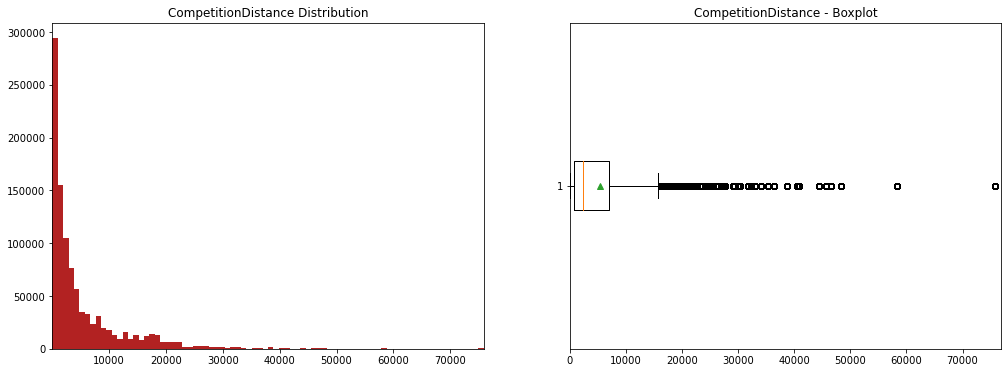

In [16]:
#Distribution of 'CompetitionDistance'

df_CompDistDistribution = df.drop(df[pd.isnull(df.CompetitionDistance)].index)

fig, axes = plt.subplots(1, 2, figsize=(17, 6))

axes[0].hist(df_CompDistDistribution.CompetitionDistance, cumulative=False, color='firebrick', bins=80)
axes[0].set_title("CompetitionDistance Distribution")
axes[0].set_xlim((min(df_CompDistDistribution.CompetitionDistance), max(df_CompDistDistribution.CompetitionDistance)))

axes[1].boxplot(df_CompDistDistribution.CompetitionDistance, showmeans=True, vert=False)
axes[1].set_xlim(0, max(df_CompDistDistribution.CompetitionDistance + 1000))
axes[1].set_title('CompetitionDistance - Boxplot')

#These values are significantly different:
print({"Mean": np.nanmean(df_CompDistDistribution.CompetitionDistance), 
       "Median": np.nanmedian(df_CompDistDistribution.CompetitionDistance), 
       "Std": np.nanstd(df_CompDistDistribution.CompetitionDistance)})

**Solution:** <br>
Given the skewed distribution and only three stores lacking information, it is recommended to impute missing values with the median instead of the mean. Using the median provides a more robust estimate of the central tendency of the 'CompetitionDistance' column. The median is less affected by outliers than the mean, making it a better measure of central tendency for skewed data. 

Therefore, filling the missing values with the median is a suitable approach.

In [17]:
# filling the missing values with median
df['CompetitionDistance'].fillna(value = df['CompetitionDistance'].median(), inplace=True)

#Checking the results:
if ~df['CompetitionDistance'].isna().sum(): print('CompetitionDistance was succesufully fill in.')

CompetitionDistance was succesufully fill in.


In [18]:
#free-up memory:
del df_CompDistDistribution
if not 'df_CompDistDistribution' in locals(): print('df_CompDistDistribution is not in locals')

df_CompDistDistribution is not in locals


**Note after modeling part:**

**The solution presented above offers a recommended approach for handling missing values in scenarios where there are more than three missing values. It showcases an effective and widely accepted practice.** However, in instances where the missing values have negligible impact on the model, those observations may be excluded from the dataset. The decision of how to handle these observations will be made during the modeling phase, taking into consideration the specific requirements and objectives of the analysis.

____

### CompetitionOpenSinceMonth/Year (both: 32 %)

In [19]:
#The number of missing observations is the same for both columns.
print(df[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].isna().sum(),'\n')

#Verification whether these are the same observations:

if df.loc[df[['CompetitionOpenSinceMonth', 
                          'CompetitionOpenSinceYear']].isna().all(axis=1)].shape[0] \
                           == df['CompetitionOpenSinceMonth'].isna().sum(): 
    print('Rows with missing values for both columns are the same.')

CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
dtype: int64 

Rows with missing values for both columns are the same.


**Solution:**

The number of missing values is identical for both columns in each row, indicating that they correspond to the same issue.

As there is no available information for the missing values and there is no accurate method to fill them, a possible approach could be:
- to use a multilabel classification algorithm to train on the non-NaN fields and then predict the most probable month and year for the missing fields (this approach is computationally intensive and not practical for the current analysis),
- to fill the missing values with 0.

Considering the aforementioned findings, it has been decided to fill the missing values with 0.

In [20]:
df['CompetitionOpenSinceYear'].fillna(0, inplace = True)
df['CompetitionOpenSinceMonth'].fillna(0,inplace=True)

#Checking the results:
if ~df[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].isna().sum().all(): print('CompetitionOpenSinceYear & CompetitionOpenSinceMonth was succesufully fill in.')

CompetitionOpenSinceYear & CompetitionOpenSinceMonth was succesufully fill in.


**Note after modeling part:**

In general, these columns will be dropped and transformed into a more valuable feature, such as "CompetitionSinceMonth". However, it should be noted that there are still a significant number of missing values that need to be addressed. At this stage, it may not be worthwhile to drop these missing values immediately. During test phase of modeling this approche gave gode results.

______

### Promo2_since_week, Promo2_since_year, Promo_interval (all aprox. 50%)

In [21]:
##Number of missing values for Promo2SinceWeek', 'Promo2SinceYear','PromoInterval' 544/1115
df[['Promo2SinceWeek', 'Promo2SinceWeek', 'PromoInterval']].isna().sum()

Promo2SinceWeek    508031
Promo2SinceWeek    508031
PromoInterval      508031
dtype: int64

In [22]:
#All the missing values are strongly conected with fields where Promo2=0 which means there are no continuous promotional activities for those stores. 
df[df.Promo2 == 0][['Promo2SinceWeek', 'Promo2SinceWeek','PromoInterval']].isna().sum()

Promo2SinceWeek    508031
Promo2SinceWeek    508031
PromoInterval      508031
dtype: int64

**Solution:** <br>
Based on the information available, it can be determined that the missing values in the fields are related to stores where Promo2=0, indicating the absence of continuous promotional activities. 
Therefore, it is appropriate to assign a value of 0 to these missing fields, given that they are directly linked to Promo2.

In [23]:
# filling the missing values with zero.
df["Promo2SinceWeek"].fillna(value = 0, inplace=True)
df["Promo2SinceYear"].fillna(value = 0, inplace=True)
df["PromoInterval"].fillna(value = 0, inplace=True)

In [24]:
if ~df.isna().values.sum(): print('df dataset was succesufully fill in.') 

df dataset was succesufully fill in.


**Note after modeling part:**

In general, these columns will be dropped and transformed into a more valuable feature.

_____

## Handling outliers & zero values:

### Closed stores and zero sales stores

In this section, we will investigate the cases where sales are equal to zero. Our initial hypothesis was that zero sales occur when the store is closed.

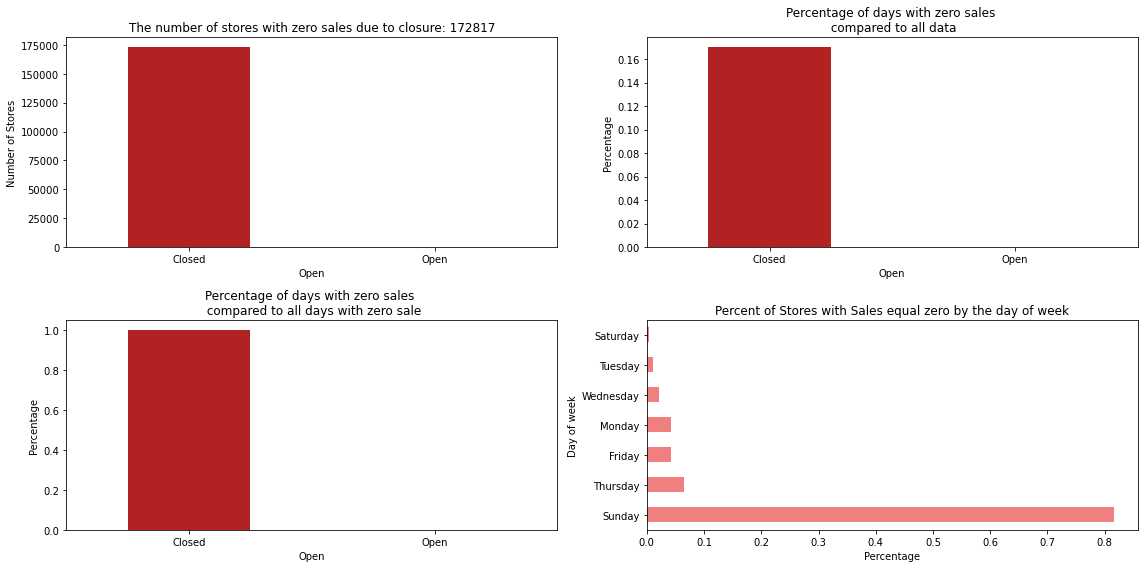

In [25]:
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

# Figure 1 - The number of stores with zero sales due to closure.
df.query('Sales == 0').groupby('Open')['Store'].agg('count').plot(kind='bar', color = 'firebrick', ax=axs[0][0])
axs[0][0].set_title(f'The number of stores with zero sales due to closure: {df.query("Sales == 0 and Open == 0")["Store"].count()}')
axs[0][0].set_ylabel('Number of Stores')
axs[0][0].set_xticklabels(['Closed', 'Open'], rotation=0)

# Figure 2 - percentage of days with zero sales compared to all days
(df.query('Sales == 0').groupby('Open')['Store'].agg('count') / len(df)).plot(kind='bar', color='firebrick', ax=axs[0][1])
axs[0][1].set_title('Percentage of days with zero sales \n compared to all data')
axs[0][1].set_ylabel('Percentage')
axs[0][1].set_xticklabels(['Closed', 'Open'], rotation=0)

# Figure 3 - percentage of days with zero sales compared to all days with zero sale
(df.query('Sales == 0').groupby('Open')['Store'].agg('count') / len(df.query('Sales == 0'))).plot(kind='bar', color='firebrick', ax=axs[1][0])
axs[1][0].set_title('Percentage of days with zero sales \n compared to all days with zero sale')
axs[1][0].set_ylabel('Percentage')
axs[1][0].set_xticklabels(['Closed', 'Open'], rotation=0)

# Figure 4 - percentage of stores with sales equal to zero for each day of the week when the store was closed
(df.query('Open == 0')['DayOfWeek'].value_counts() / len(df.query('Open == 0'))).plot(kind='barh', color='lightcoral', ax=axs[1][1])
axs[1][1].set_title('Percent of Stores with Sales equal zero by the day of week')
axs[1][1].set_xlabel('Percentage')
axs[1][1].set_ylabel('Day of week')
axs[1][1].set_yticklabels(df.query('Open == 0')['DayOfWeek'].value_counts().index.map(lambda x: weekday_names[x-1]))

plt.tight_layout()
plt.show()

In [26]:
#free-up memory
del weekday_names, fig, axs
if not all(elem in locals() for elem in ['weekday_names', 'fig', 'axs']) in locals(): print('weekday_names, fig, axs are not in locals')

weekday_names, fig, axs are not in locals


In [27]:
#Stores ID were Sales = 0 and Open = 1 (there are only 54 cases)
df_sales.query('Sales == 0 and Open == 1')['Store'].value_counts()[:3]

28     3
364    2
102    2
Name: Store, dtype: int64

**Solution:**

Based on the analysis of the data, the following findings have been identified:

- Approximately 17% of the data has zero sales due to the closure of stores.
- Over 80% of stores were closed on Sundays, which is likely due to it being a non-working day in Germany.
- There were only 54 stores with sales equal to zero and open status equal to one. These stores were closed for a maximum of three days, possibly due to renovation or other reasons.

To ensure unbiased forecasts, it is recommended to exclude closed stores from the analysis. By doing so, the models will not be trained on data that can lead to inaccurate predictions. Therefore, we will only analyze the data of open stores, as closed stores have zero profit.

In [28]:
df = df.loc[df.Open != 0]
df = df.loc[df.Sales > 0].reset_index(drop=True)

In [29]:
df.shape

(844338, 18)

### Handling Outliers:

#### Sales & Customers

Given that we have previously established (on Pandas Profile Report) a strong linear relationship between sales and customers, it is recommended to perform outlier detection for both variables simultaneously. By doing so, we can ensure that the detection and subsequent removal of outliers is more precise and efficient.

In [30]:
#The Pearson correlation coefficient between Sales & Customers
df.Sales.corr(df.Customers)

0.8235517202000227

In [31]:
#Descriptive statistics for numeric feature:
df.select_dtypes(include=np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
Store,844338.0,558.421374,321.730861,1.0,280.0,558.0,837.0,1115.0
DayOfWeek,844338.0,3.520350,1.723712,1.0,2.0,3.0,5.0,7.0
Sales,844338.0,6955.959134,3103.815515,46.0,4859.0,6369.0,8360.0,41551.0
Customers,844338.0,762.777166,401.194153,8.0,519.0,676.0,893.0,7388.0
Open,844338.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Promo,844338.0,0.446356,0.497114,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,844338.0,0.193578,0.395102,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,844338.0,5450.057797,7801.076826,20.0,710.0,2330.0,6880.0,75860.0
CompetitionOpenSinceMonth,844338.0,4.926482,4.283634,0.0,0.0,4.0,9.0,12.0
CompetitionOpenSinceYear,844338.0,1369.692738,935.556484,0.0,0.0,2006.0,2011.0,2015.0


Based on the descriptive statistics analysis, preliminary findings indicate the presence of potential outliers in the following features: Sales, Customers, and CompetitionDistance. 
It is observed that these particular features exhibit values that deviate significantly from the majority of the data points.
However, no such outliers were detected in the analysis of other features, suggesting their relative stability and consistency in comparison. These initial findings warrant further investigation to determine the nature and impact of the identified outliers on the overall data analysis and any subsequent modeling or decision-making processes.

##### Store Type & Assortment
Since each store type & assortment exhibits sales figures within a distinct range, it is recommended to perform outlier detection on a store type basis rather than aggregating all store types together. This approach would provide more accurate and reliable results in terms of identifying and handling outliers.

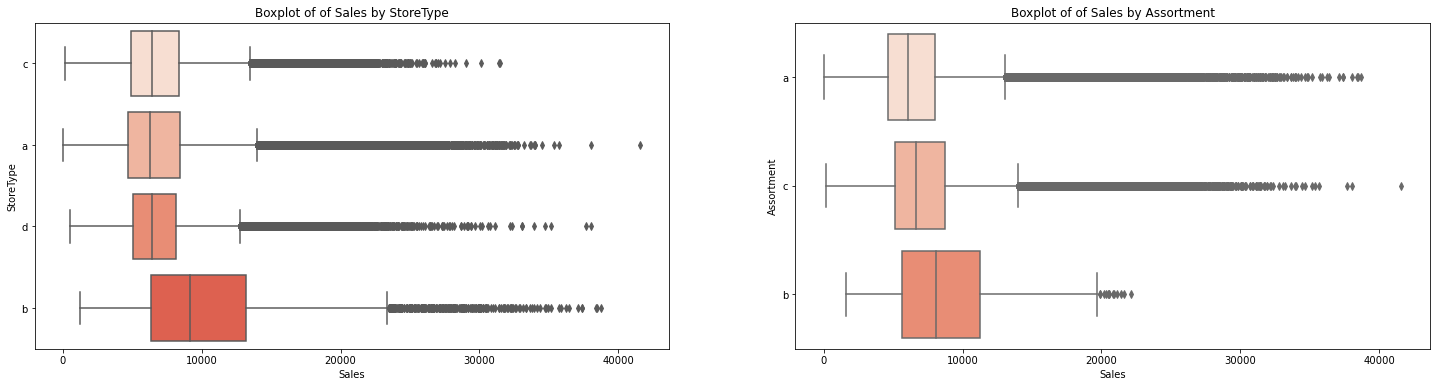

Outliers in Sales vs StoreType & Assortment calculated on Tukey's method: 

Number of outliers in Sales for StoreType a : 16993 (3.72%)
Number of outliers in Sales for StoreType b : 247 (1.59%)
Number of outliers in Sales for StoreType c : 3647 (3.23%)
Number of outliers in Sales for StoreType d : 7092 (2.74%)
------------------------------------------------------------
Number of outliers in Sales for Assortment d : 14569 (3.27%)
Number of outliers in Sales for Assortment d : 13 (0.16%)
Number of outliers in Sales for Assortment d : 15561 (3.98%)


In [32]:
#Generate box plots of Sales for each unique value of StoreType & Assortment:
sns.set_palette("Reds")
fig, axs = plt.subplots(1, 2, figsize=(25, 6))
sns.boxplot(data=df, x="Sales", y="StoreType", ax = axs[0])
axs[0].set_title("Boxplot of of Sales by StoreType")
sns.boxplot(data=df, x="Sales", y="Assortment", ax = axs[1])
axs[1].set_title("Boxplot of of Sales by Assortment")
plt.show()

#Get unique values of StoreType
store_types = sorted(df['StoreType'].unique().tolist())
assortments = sorted(df['Assortment'].unique().tolist())

#Calculate count and percentage of outliers in each StoreType & Assortment  based on Tukey's method
print("Outliers in Sales vs StoreType & Assortment calculated on Tukey's method: \n")

for store_type in store_types:
    count, percentage = utl.tukey_method_outlier_count_and_percentage(df[df['StoreType'] == store_type], 'Sales')
    print(f"Number of outliers in Sales for StoreType {store_type} : {count} ({percentage}%)")

print('-' * 60)
for assortment in assortments:
    count, percentage = utl.tukey_method_outlier_count_and_percentage(df[df['Assortment'] == assortment], 'Sales')
    print(f"Number of outliers in Sales for Assortment {store_type} : {count} ({percentage}%)")

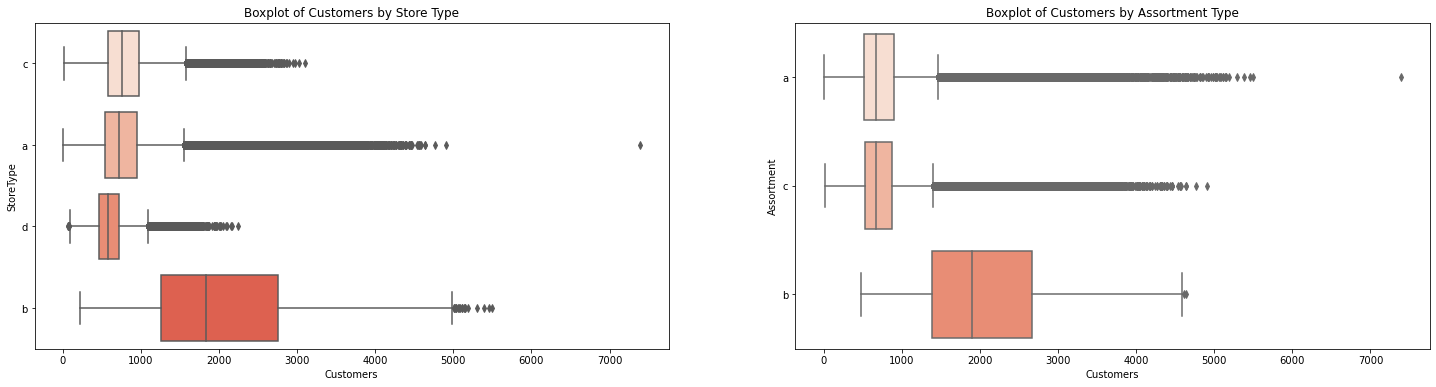

Outliers in Sales vs StoreType & Assortment calculated on Tukey's method: 

Number of outliers in Sales for StoreType a : 19287 (4.22%)
Number of outliers in Sales for StoreType b : 18 (0.12%)
Number of outliers in Sales for StoreType c : 3454 (3.06%)
Number of outliers in Sales for StoreType d : 5843 (2.26%)
------------------------------------------------------------
Number of outliers in Sales for Assortment a : 17507 (3.94%)
Number of outliers in Sales for Assortment b : 2 (0.02%)
Number of outliers in Sales for Assortment c : 19117 (4.89%)


In [33]:
#Generate box plots of Sales for each unique value of StoreType & Assortment:
sns.set_palette("Reds")
fig, axs = plt.subplots(1, 2, figsize=(25, 6))

sns.boxplot(data=df, x="Customers", y="StoreType", ax=axs[0])
axs[0].set_title("Boxplot of Customers by Store Type")

sns.boxplot(data=df, x="Customers", y="Assortment", ax=axs[1])
axs[1].set_title("Boxplot of Customers by Assortment Type")
plt.show()

#Get unique values of StoreType
store_types = sorted(df['StoreType'].unique().tolist())
assortments = sorted(df['Assortment'].unique().tolist())

#Calculate count and percentage of outliers in each StoreType & Assortment based on Tukey's method
print("Outliers in Sales vs StoreType & Assortment calculated on Tukey's method: \n")

for store_type in store_types:
    count, percentage = utl.tukey_method_outlier_count_and_percentage(df[df['StoreType'] == store_type], 'Customers')
    print(f"Number of outliers in Sales for StoreType {store_type} : {count} ({percentage}%)")

print('-' * 60)
for assortment in assortments:
    count, percentage = utl.tukey_method_outlier_count_and_percentage(df[df['Assortment'] == assortment], 'Customers')
    print(f"Number of outliers in Sales for Assortment {assortment} : {count} ({percentage}%)")

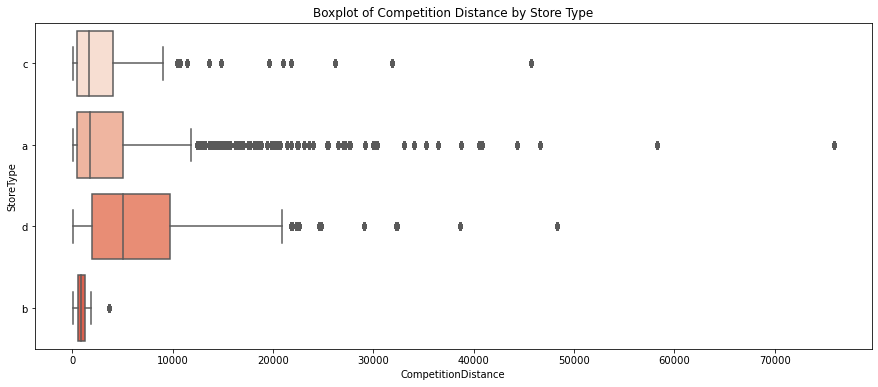

Number of outliers in Sales for StoreType a : 70410 (15.41%)
Number of outliers in Sales for StoreType b : 932 (5.99%)
Number of outliers in Sales for StoreType c : 8321 (7.37%)
Number of outliers in Sales for StoreType d : 9416 (3.64%)


In [34]:
#Generate box plots of Sales for each unique value of StoreType & Assortment:
plt.figure(figsize=(15,6))
sns.set_palette("Reds")
ax = sns.boxplot(data=df, x="CompetitionDistance", y="StoreType")
ax.set_title("Boxplot of Competition Distance by Store Type")
plt.show()

for store_type in store_types:
    count, percentage = utl.tukey_method_outlier_count_and_percentage(df[df['StoreType'] == store_type], 'CompetitionDistance')
    print(f"Number of outliers in Sales for StoreType {store_type} : {count} ({percentage}%)")

**Conclusion:**

To ensure data correctness, outliers were identified and investigated using a box plot. These cases require further investigation to determine if the significant sales volume observed on specific days can be attributed to factors such as promotional activities, store popularity, or a lack of competition resulting in a regional monopoly. The corresponding charts and analysis will be presented in the explanatory data analysis section.

**Note:**

Various techniques for selecting and removing outliers did not yield satisfactory results in terms of model performance & metrics. Finally, **the analysis of seasonal patterns confirmed that the high peaks in sales are associated with seasonal behavior.** 

______

### Optimizing Memory Usage and Data Types

In [35]:
#characteristics of the dataframe prior to optimization:

display((df.dtypes.to_frame().T))
print(f'df shape: {df.shape}')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,int64,int64,object,int64,int64,int64,int64,object,int64,object,object,float64,float64,float64,int64,float64,float64,object


df shape: (844338, 18)


In [36]:
#Custom user-defined function for optimizing a dataframe:

help(utl.optimize)

Help on function optimize in module utils:

optimize(df: pandas.core.frame.DataFrame, datetime_features: List[str] = [], bool_features: List[str] = [])
    The function optimize takes a pandas DataFrame as input, along with an optional list of column names (datetime_features) that are supposed to be of
    datetime type, and an optional list of column names (bool_features) that are supposed to be of bool type. The function optimizes the memory usage of 
    integer, float, and object columns in the DataFrame using the optimize_objects, optimize_ints, and optimize_floats functions.
    
    The function first calculates the memory usage of the input DataFrame using sys.getsizeof method. It then calls the three optimization functions in the
    following order: optimize_objects, optimize_ints, and optimize_floats.
    
    After the optimization is complete, the function prints out the percentage of memory reduction achieved by the optimization. 
    Finally, the function does not return

In [37]:
#Optimalization:
utl.optimize(df,['Date'])

Optimize_memory_func reduce memory usage by 88.67 %.


In [38]:
#Characteristics of the dataframe after optimization:
display(df.dtypes.to_frame().T)
print(f'df shape: {df.shape}')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,int16,int8,datetime64[ns],int32,int16,int8,int8,category,int8,category,category,float32,float32,float32,int8,float32,float32,category


df shape: (844338, 18)


**Observations to consider after optimizing the memory usage of the dataframe:**
- the memory usage was successfully reduced from 116+ MB to 36.2 MB.
- the data types of the features were appropriately changed, especially in the case of the 'Date' feature.
____

______________

## Exploratory Data Analysis

### StoreType

In this section, there will be conducted a detailed analysis of the various StoreType levels and examine how the primary metric Sales & Customers is distributed among them.

In [39]:
#Pandas display settings:

pd.set_option('display.float_format',  '{:,.2f}'.format)

In [40]:
df.groupby('StoreType')[['Sales','Customers']].describe().T

StoreType                a         b          c          d
Sales     count 457,042.00 15,560.00 112,968.00 258,768.00
          mean    6,925.70 10,233.38   6,933.13   6,822.30
          std     3,277.35  5,155.73   2,896.96   2,556.40
          min        46.00  1,252.00     133.00     538.00
          25%     4,695.25  6,345.75   4,916.00   5,050.00
          50%     6,285.00  9,130.00   6,408.00   6,395.00
          75%     8,406.00 13,184.25   8,349.25   8,123.25
          max    41,551.00 38,722.00  31,448.00  38,037.00
Customers count 457,042.00 15,560.00 112,968.00 258,768.00
          mean      795.42  2,022.21     815.54     606.35
          std       387.52    910.69     329.67     199.25
          min         8.00    219.00      18.00      64.00
          25%       547.00  1,255.00     583.00     464.00
          50%       720.00  1,839.50     756.00     577.00
          75%       949.00  2,751.00     981.00     716.00
          max     7,388.00  5,494.00   3,096.00   2,239.00

StoreType B has the highest average Sales among all other StoreTypes, although the data available for it is relatively limited (as it represents the smallest group of stores). To determine the StoreType with the highest overall Sales and customer traffic, we will print the sum of these metrics across all StoreTypes.

In [41]:
#Sales per Customers could bring usefull insights:

df['SalesPerCustomer']=df['Sales']/df['Customers']

Sales                Customers           \
                       sum      mean            sum     mean   
StoreType                                                      
a         3,165,334,859.00  6,925.70 363,541,431.00   795.42   
b           159,231,395.00 10,233.38  31,465,616.00 2,022.21   
c           783,221,426.00  6,933.13  92,129,705.00   815.54   
d         1,765,392,943.00  6,822.30 156,904,995.00   606.35   

          Average Spending per Customer Number of Stores  \
                                   mean            count   
StoreType                                                  
a                                  8.85           457042   
b                                  5.13            15560   
c                                  8.63           112968   
d                                 11.28           258768   

          Mean Competition Distance  
                               mean  
StoreType                            
a                          5,222.91  
b                          1,072.57  
c                          3,514.15  
d                          6,959.62

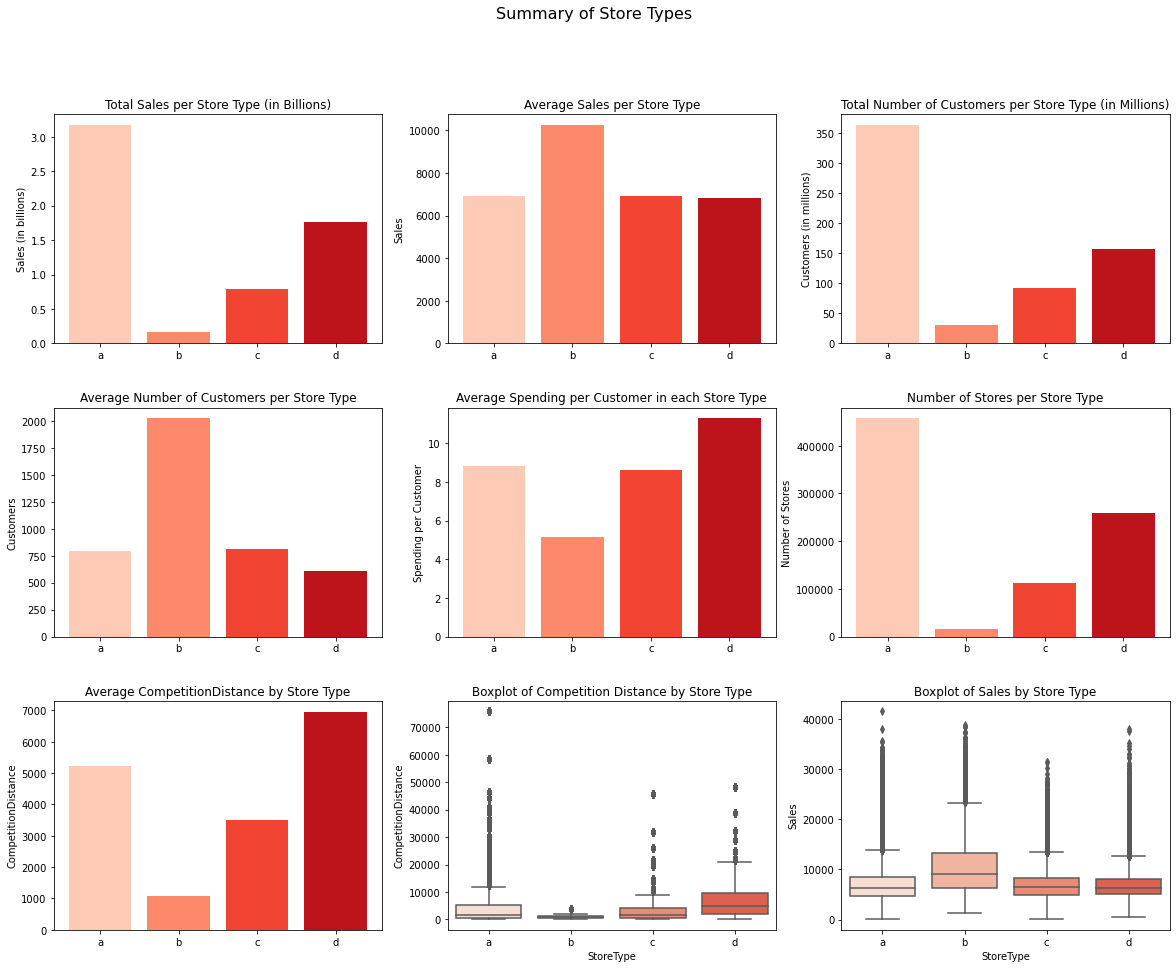

In [42]:
display(
    df.groupby('StoreType').agg({
    'Sales': ['sum', 'mean'],
    'Customers': ['sum', 'mean'],
    'SalesPerCustomer': 'mean',
    'Store': 'count',
    'CompetitionDistance': 'mean'
}).rename(columns={
    'sum': 'sum',
    'mean': 'mean'
}).rename(columns={
    'Total_Sales': 'Total Sales',
    'Total_Customers': 'Total Customers',
    'Store': 'Number of Stores',
    ('Mean', 'Sales'): 'Mean Sales',
    ('Mean', 'Customers'): 'Mean Customers',
    'CompetitionDistance': 'Mean Competition Distance',
    'SalesPerCustomer': 'Average Spending per Customer'
})
)


fig, axes = plt.subplots(3, 3, figsize=(20, 15))
palette = sns.color_palette("Reds", n_colors=4)
plt.subplots_adjust(hspace=0.28)

fig.suptitle('Summary of Store Types', fontsize=16)

# define variables for each plot
variables = [
    (df.groupby(by="StoreType").sum().Sales/1e9, "Total Sales per Store Type (in Billions)", "Sales (in billions)"),
    (df.groupby(by="StoreType").Sales.mean(), "Average Sales per Store Type", "Sales"),
    (df.groupby(by="StoreType").sum().Customers/1e6, "Total Number of Customers per Store Type (in Millions)", "Customers (in millions)"),
    (df.groupby(by="StoreType").Customers.mean(), "Average Number of Customers per Store Type", "Customers"),
    (df.groupby(by="StoreType").SalesPerCustomer.mean(), "Average Spending per Customer in each Store Type", "Spending per Customer"),
    (df.groupby(by="StoreType").count().Store, "Number of Stores per Store Type", "Number of Stores"),
    (df.groupby(by='StoreType').CompetitionDistance.mean(),"Average CompetitionDistance by Store Type", "CompetitionDistance")
]

# loop through the variables and plot them
for i, (data, title, ylabel) in enumerate(variables):
    ax = axes[i//3, i%3]
    ax.bar(data.index, data.values, color=palette)
    ax.set_title(title)
    ax.set_ylabel(ylabel)

# Add the boxplot of competition distance by store type
sns.set_palette("Reds")
ax = axes[2, 1]
sns.boxplot(x='StoreType', y='CompetitionDistance', data=df, ax=ax)
ax.set_title("Boxplot of Competition Distance by Store Type")

# Add the boxplot of sales by store type
ax = axes[2, 2]
sns.boxplot(x='StoreType', y='Sales', data=df, ax=ax)
ax.set_title("Boxplot of Sales by Store Type")

# Show the plots
plt.show()

**Several interesting findings:**

- Storetype A has the highest number of stores, revenue, and customers among the four different storetypes. However, this does not necessarily imply that Storetype A is the best performing storetype.
- When considering the average sales and the number of customers, Storetype B has the highest average sales and the highest average number of customers. This suggests that Storetype B might be some special kind of Rossmann store will larger area, whereas Storetype A may be smaller in size but more widespread.
- Surprisingly, Storetype D has the highest average spending per customer. This is likely explained by an average competition distance higher than the rest, which means each customer will buy more because there are not many similar shops around (taking into consideration possible outliers).

To better understand these findings, it would be helpful to look coloser to other variables that explain this behavior, such as assortments, competition, and promotions.

_____

### Assortments

As previously stated in the description, the assortments in this context are categorized into three types, namely: 
- "a" representing basic items, 
- "b" representing extra items, and,
- "c" representing extended items with the highest variety of products. 

Each store is assigned a specific type and assortment based on this categorization.

An interesting analysis would be to examine the relationship between a store's type and its respective assortment type.

Sales               Customers         
                        sum     mean            sum     mean
Assortment                                                  
a          2,945,750,070.00 6,621.52 332,766,935.00   748.00
b             70,946,312.00 8,642.50  16,972,520.00 2,067.55
c          2,856,484,241.00 7,300.84 294,302,292.00   752.20

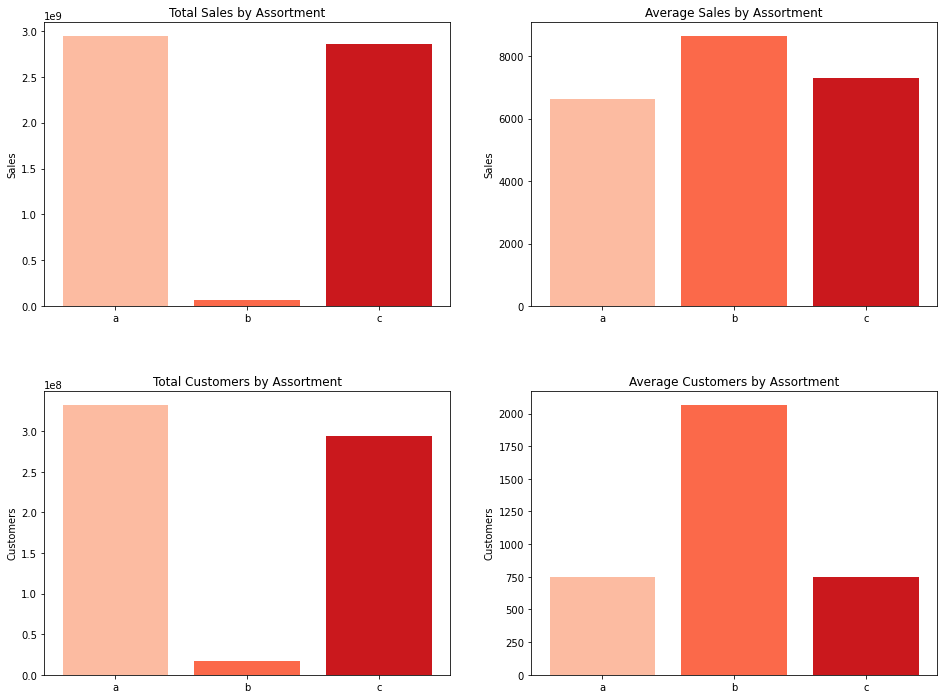

In [43]:
display(
    df.groupby('Assortment').agg({
    'Sales': ['sum', 'mean'],
    'Customers': ['sum', 'mean']
}))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
palette = sns.color_palette("Reds", n_colors=3)
plt.subplots_adjust(hspace=0.3)

variables = [
    (df.groupby(by='Assortment')['Sales'].agg('sum'), "Total Sales by Assortment", "Sales"),
    (df.groupby(by='Assortment')['Sales'].agg('mean'), "Average Sales by Assortment", "Sales"),
    (df.groupby(by='Assortment')['Customers'].agg('sum'), "Total Customers by Assortment", "Customers"),
    (df.groupby(by='Assortment')['Customers'].agg('mean'), "Average Customers by Assortment", "Customers"),
]

for i, (data, title, ylabel) in enumerate(variables):
    ax = axes[i//2, i%2]
    ax.bar(data.index, data.values, color=palette)
    ax.set_title(title)
    ax.set_ylabel(ylabel)

plt.show()


Despite having a low volume of sales and customers, assortment b has the highest average sales and customers. This indicates that there is a high demand for assortment b.

Let's examine the sales volume for each assortment in various store types.

_____

StoreType        A                B                 C                D     \
Assortment       a  b       c     a     b    c      a  b      c      a  b   
Assortment  286028  0  171014  6409  8209  942  58554  0  54414  93884  0   

StoreType           
Assortment       c  
Assortment  164884

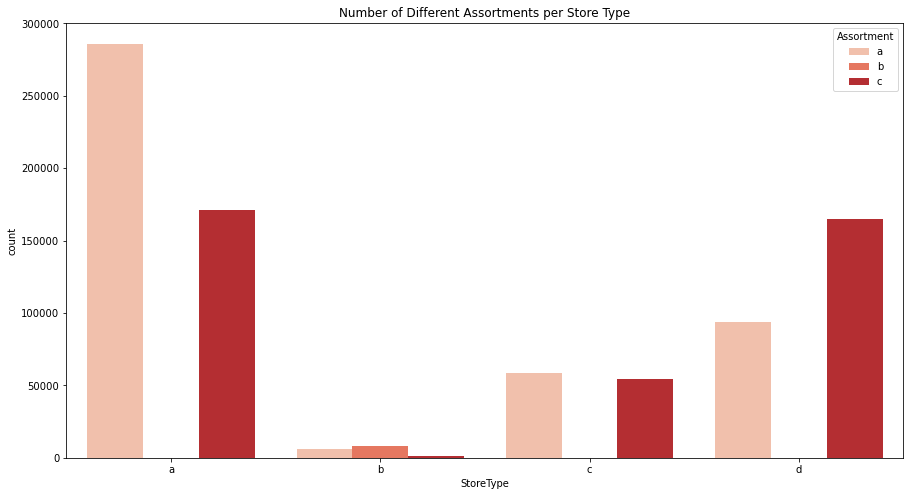

In [44]:
plt.figure(figsize=(15,8))
sns.countplot(
    x="StoreType",
    hue="Assortment",
    data=df,
    order=sorted(df['StoreType'].unique().tolist()),
    palette=sns.color_palette("Reds", n_colors=3)
).set_title("Number of Different Assortments per Store Type")

display(
    df.groupby(by=["StoreType","Assortment"])\
        .Assortment.count().to_frame().\
        rename(index={"a":"A", "b":"B", "c":"C", "d":"D"}, level="StoreType").T
)

**Several interesting findings:**

- The analysis reveals that the majority of stores have either an "a" or "c" assortment type, indicating that customers prefer either basic products or a wide variety of products.
- One interesting finding is that StoreType "d," which has the highest Sales per customer average, mainly has "c" assortment type stores. This suggests that the reason for the high average sales per customer in these stores could be due to the diverse range of products available, which motivates customers to spend more. This finding emphasizes the significance of having product variety in stores to increase customer spending.
- Another notable discovery is that only store type "b" has the "b" assortment type, and many of them. The "b" assortment type stands for "extra," and based on the data, it is the store type with the highest number of customers and sales. It is possible that the "extra" formula provides a balance between not having too much variety like "c" assortment type and not being too basic like "a" assortment type, which attracts more customers to this store. This finding underscores the importance of striking the right balance in product variety to drive customer traffic and sales.
_____

### CompetitionDistance

It could be interesting to investigate the influence of the closest competition distance on Sales, with the aim of ascertaining whether stores situated in close proximity to their competitors achieve lower sales compared to those located at a greater distance.

In order to conduct this analysis, the continuous variable CompetitionDistance will be transformed into a categorical variable consisting of five distinct bins. This categorization will enable the visualization and interpretation of the relationship between competition distance and sales, while ensuring a visually appealing representation of the data.

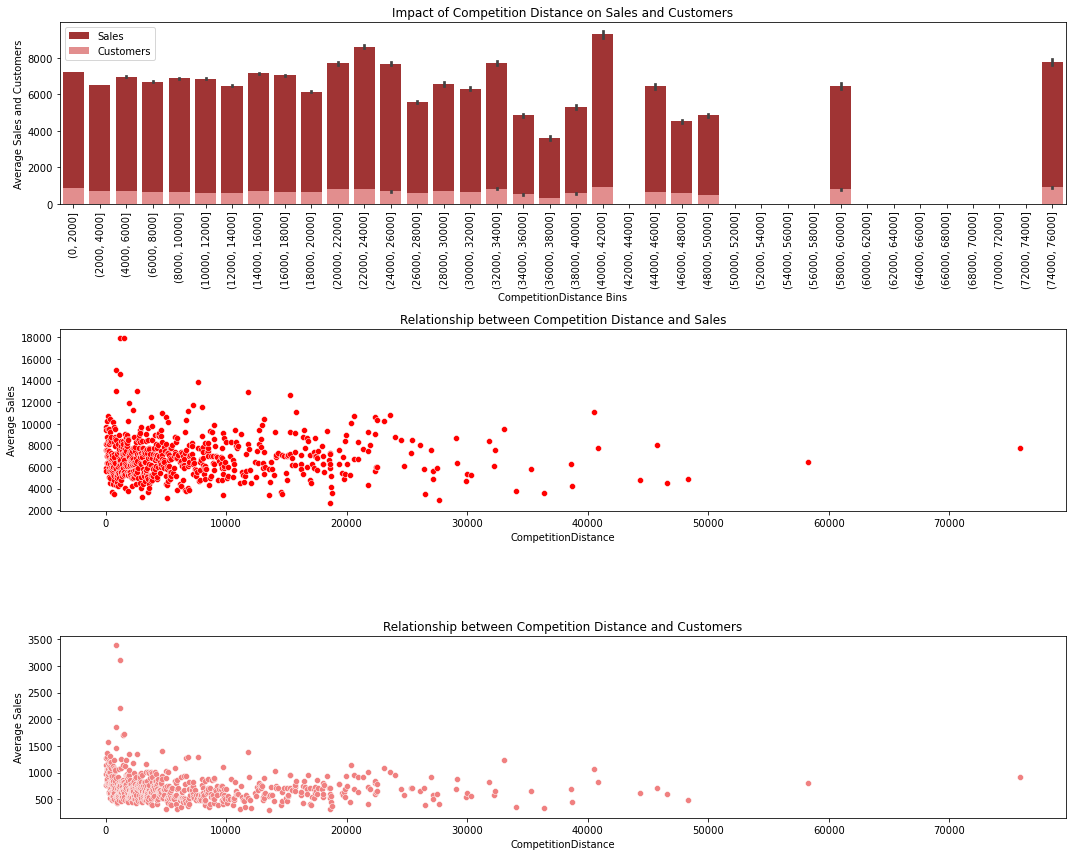

Pearson correlation between Sales and Competition distance: -0.0359


In [45]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Barplot
df['CompetitionDistance_bins'] = pd.cut(df.CompetitionDistance, bins=range(0, int(df.CompetitionDistance.max())+2000, 2000))

sns.barplot(
            data=df, 
            x='CompetitionDistance_bins', 
            y='Sales', 
            color='firebrick', 
            ax=axes[0], 
            label='Sales'
)

sns.barplot(
            data=df, 
            x='CompetitionDistance_bins', 
            y='Customers', 
            color='lightcoral', 
            ax=axes[0], 
            label='Customers'
)

axes[0].set_xlabel('CompetitionDistance Bins')
axes[0].set_ylabel('Average Sales and Customers')
axes[0].set_title('Impact of Competition Distance on Sales and Customers')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend()

# Scatter_plot
fig_data = df[['CompetitionDistance', 'Sales', 'Customers']].groupby('CompetitionDistance').mean()

sns.scatterplot(x=fig_data.index, y=fig_data.Sales, color='red', ax=axes[1])
sns.scatterplot(x=fig_data.index, y=fig_data.Customers, color='lightcoral', ax=axes[2])
axes[1].set_xlabel('CompetitionDistance')
axes[1].set_ylabel('Average Sales')
axes[1].set_title('Relationship between Competition Distance and Sales')

axes[2].set_xlabel('CompetitionDistance')
axes[2].set_ylabel('Average Sales')
axes[2].set_title('Relationship between Competition Distance and Customers')

plt.tight_layout()
plt.show()

print("Pearson correlation between Sales and Competition distance: {:.4f}".format(df.Sales.corr(df.CompetitionDistance, method='pearson')))

**Findings:**

Based on the presented charts, it can be observed that there is no discernible relationship between the average sales/customer value and the distance to the nearest competitor.

_________

### Promotion

We will analyze the impact of promotions on Rossman's overall sales over a three-year period. This will allow us to assess the influence of promotions and observe sales trends within specific years, including the gradual increase from 2013 to 2015.

In [46]:
#Date extraction:

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype('int')

#Results 
#df[['Date','Year', 'Month', 'Day', 'WeekOfYear']].sample(2)

#### General Analysis Based on Totals:

Sales               Customers       
                   sum     mean            sum   mean
Promo                                                
0     2,771,974,337.00 5,929.83 325,777,807.00 696.91
1     3,101,206,286.00 8,228.74 318,263,940.00 844.48

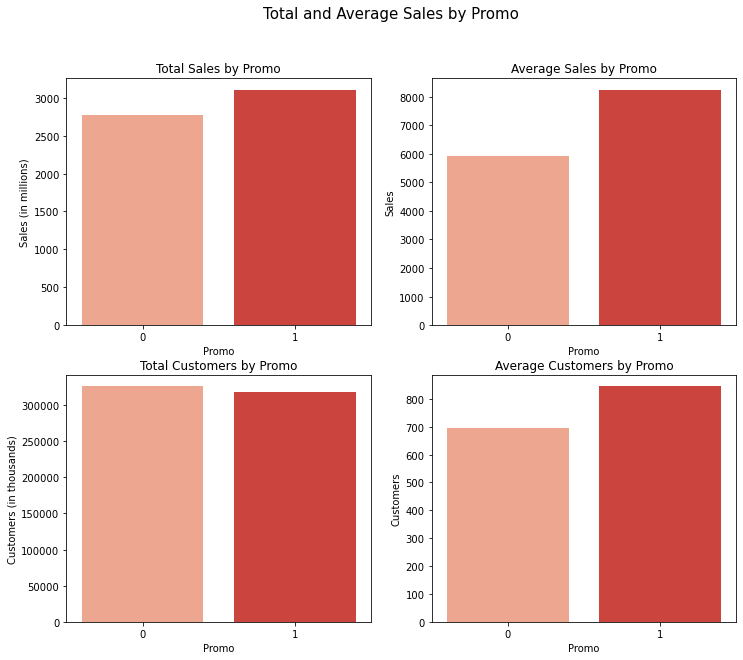

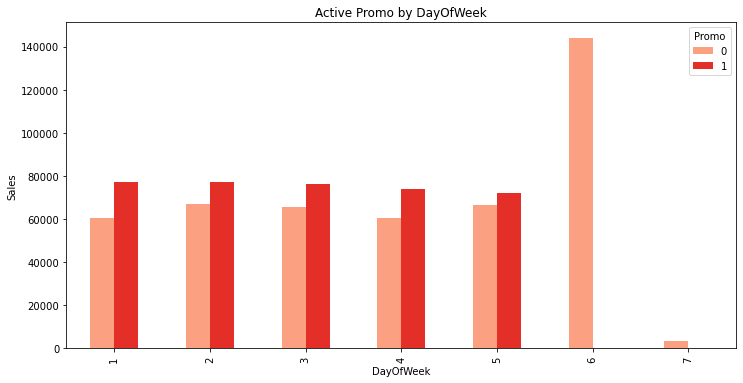

* Stores open on Sunday: 33.


In [47]:
# Display statistics for each 'Promo' category
display(
    df.groupby(by='Promo').agg(
        {'Sales' :['sum','mean'], 
         'Customers' : ['sum','mean']}
    )
)

# Set color palette
pallet = sns.set_palette("Reds", n_colors=2)

# Group data for promo statistics
promo_stats = df.groupby(by='Promo').agg({'Sales' :['sum','mean'], 'Customers' : ['sum','mean']})

# Create bar plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.barplot(
        x=promo_stats.index, 
        y=('Sales', 'sum'), 
        data=promo_stats/1e6, 
        color=pallet, 
        ax=axs[0, 0]
        )

axs[0, 0].set_ylabel('Sales (in millions)')
axs[0, 0].set_title('Total Sales by Promo')

sns.barplot(
        x=promo_stats.index, 
        y=('Sales', 'mean'), 
        data=promo_stats, 
        color=pallet, 
        ax=axs[0, 1]
    )

axs[0, 1].set_ylabel('Sales')
axs[0, 1].set_title('Average Sales by Promo')

sns.barplot(
        x=promo_stats.index, 
        y=('Customers', 'sum'), 
        data=promo_stats/1e3, 
        color=pallet, 
        ax=axs[1, 0]
    )

axs[1, 0].set_ylabel('Customers (in thousands)')
axs[1, 0].set_title('Total Customers by Promo')

sns.barplot(
        x=promo_stats.index, 
        y=('Customers', 'mean'),
        data=promo_stats, 
        color=pallet, 
        ax=axs[1, 1]
    )

axs[1, 1].set_ylabel('Customers')
axs[1, 1].set_title('Average Customers by Promo')

# Create cross-tabulation plot
(pd.crosstab(df.DayOfWeek, df.Promo)).plot(
                                           kind = 'bar', 
                                           title = 'Active Promo by DayOfWeek', 
                                           figsize = (12,6), 
                                           color =pallet
    );

plt.ylabel('Number of Customers (in hundreds)')
fig.suptitle('Total and Average Sales by Promo', fontsize=15)
plt.ylabel('Sales')
plt.show()

print(f"* Stores open on Sunday: {df.query('Open == 1 and DayOfWeek == 7')['Store'].nunique()}.")


**Several interesting findings:**

- As observed, the aforementioned analysis reveles that the presence of a promotion has a positive impact on sales. The average sales and the number of customers on days with promotions were higher compared to days without promotions.
- It is worth noting that the promotion is only applicable on working days. Surprisingly, the number of promotional days appears to be almost identical across the working days, which raises suspicions regarding its effectiveness or potential manipulation of the promotional schedule.

#### Impact of Promo/Promo2 on Sales/Basket value within Months (2013-2015)

We will analyze the impact of Promo and Promo2(designed specifically for certain stores), on sales during specific months in the period of 2013-2015.

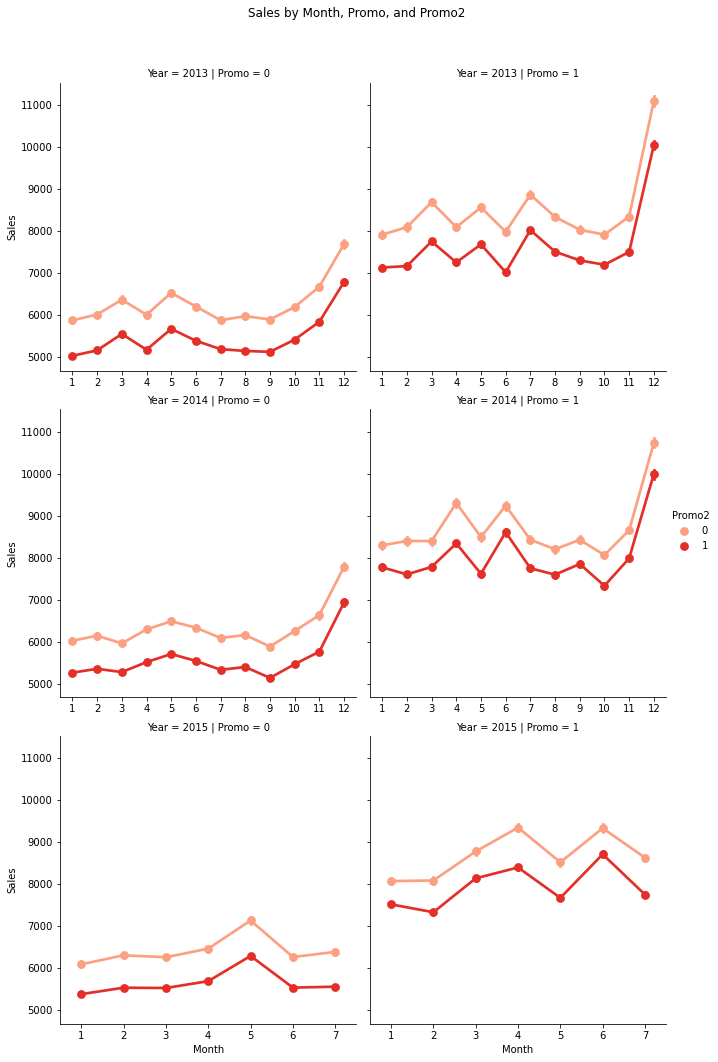

In [48]:
#Sales by Month, Promo, and Promo2
fig = sns.catplot(data=df,
                  x="Month", 
                  y="Sales",
                  kind="point", 
                  col="Promo", 
                  hue="Promo2", 
                  row="Year", 
                  palette="Reds", 
                  sharex=False)

fig.fig.set_size_inches(10, 15)  # Ustawienie rozmiaru wykresu
fig.fig.subplots_adjust(top=0.91)  # Dostosowanie górnej granicy wykresu
fig.fig.suptitle("Sales by Month, Promo, and Promo2")
plt.show()


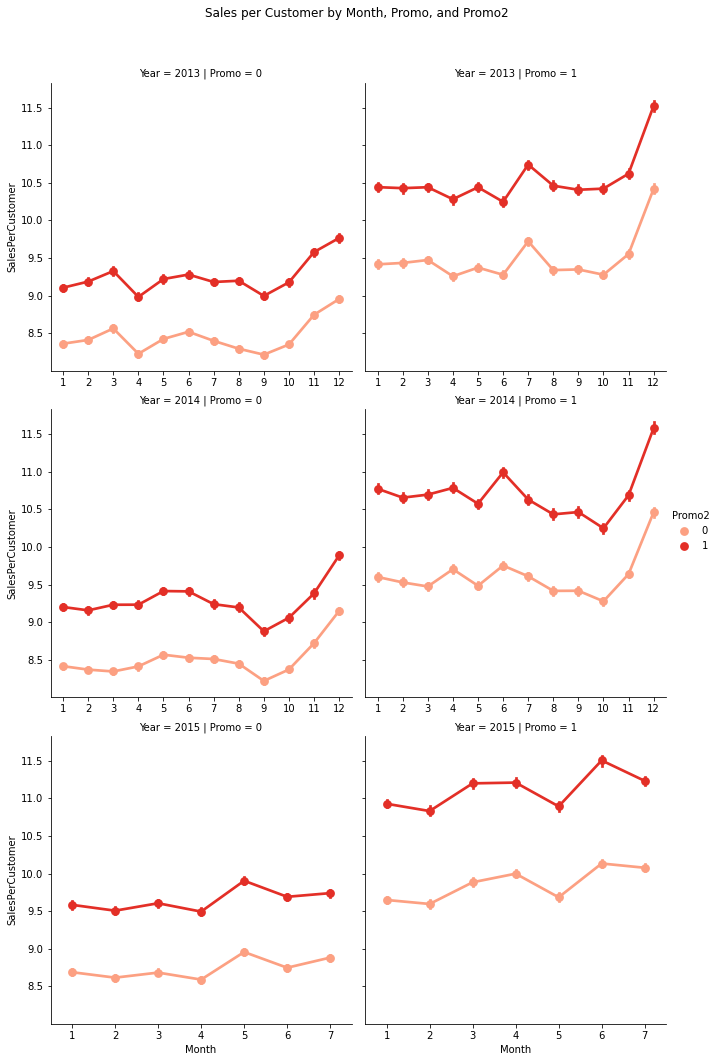

In [49]:
#Sales per Customer by Month, Promo, and Promo2
fig = sns.catplot(data=df,
                  x="Month", 
                  y="SalesPerCustomer",
                  kind="point", 
                  col="Promo", 
                  hue="Promo2", 
                  row="Year", 
                  palette="Reds", 
                  sharex=False)

fig.fig.set_size_inches(10, 15)  # Ustawienie rozmiaru wykresu
fig.fig.subplots_adjust(top=0.91)  # Dostosowanie górnej granicy wykresu
fig.fig.suptitle("Sales per Customer by Month, Promo, and Promo2")
plt.show()


**Findings:**

 - The presence of promotion (Promo=1) compared to no promotion (Promo=0) results in a significant change in the amount of sales. Stores that have promotions on a given day experience considerable variations in their sales.
- Interestingly, when examining the Promo2 variable (indicating continuous promotion), we observe that stores tend to sell more when there is no consecutive promotion compared to having consecutive promotion. This suggests that stores may have implemented this strategy to address low sales initially. Furthermore, analyzing the sales per customer reveals a remarkable increase in customer purchasing power during continuous promotions.
- Looking at the data across the years, we observe a slight year-over-year increase in sales. However, there are no major changes from 2013 to 2015. Additionally, there is a consistent pattern in sales trends throughout the months and years. Notably, there are significant spikes in sales during the Easter period in March and April, followed by increased sales during the summer months of May, June, and July. Finally, there is another peak in sales around the Christmas period in November and December.

These findings indicate the impact of promotions on sales and the consistent seasonal patterns observed throughout the analyzed years.

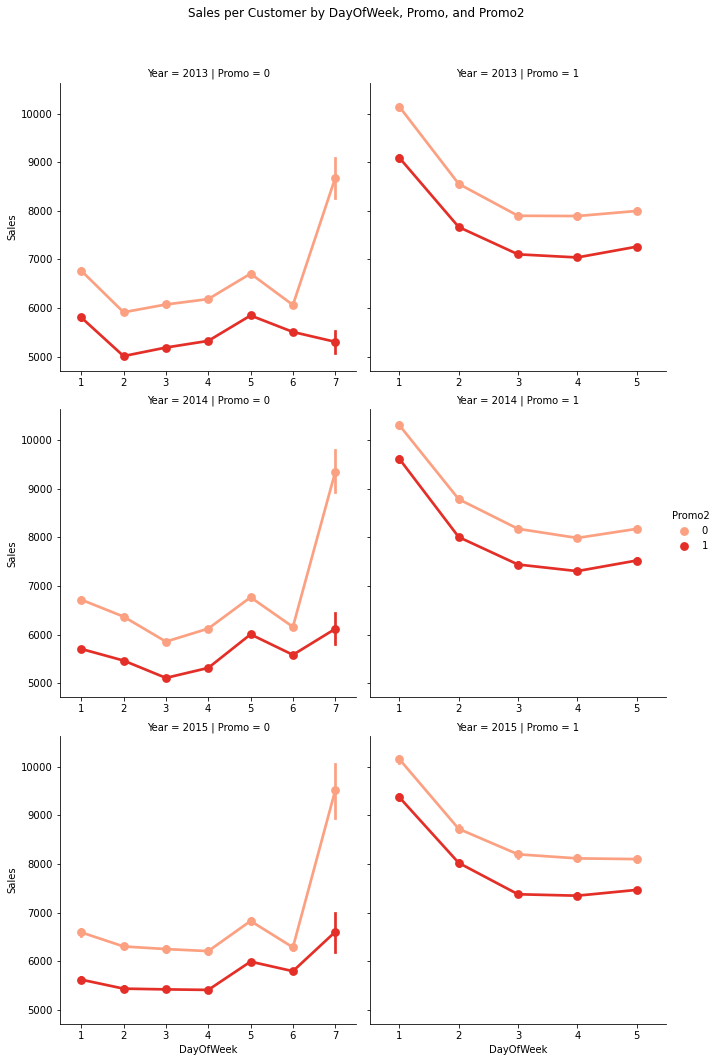

In [50]:
#Sales per Customer by Month, Promo, and Promo2
fig = sns.catplot(data=df,
                  x="DayOfWeek", 
                  y="Sales",
                  kind="point", 
                  col="Promo", 
                  hue="Promo2", 
                  row="Year", 
                  palette="Reds", 
                  sharex=False)

fig.fig.set_size_inches(10, 15)  # Ustawienie rozmiaru wykresu
fig.fig.subplots_adjust(top=0.91)  # Dostosowanie górnej granicy wykresu
fig.fig.suptitle("Sales per Customer by DayOfWeek, Promo, and Promo2")
plt.show()


**Several interesting findings:**

- Weekday Sales: There is a noticeable difference in sales when comparing promotion days (Monday to Friday) and non-promotion days. Sales tend to be higher on promotion days. Interestingly, there are no promotions during the weekend.
- Sunday Sales: Sundays show a significant peak in sales. This can be attributed to the fact that very few stores (only 33) are open on Sundays. If someone urgently needs to make a purchase and doesn't have the opportunity during the week, they would have to travel some distance to reach one of the open stores, even if it's not close to their home. These 33 open stores on Sundays represent the potential demand if all Rossmann stores were closed on Sundays. This highlights the importance of stores being open on Sundays.
- Weekly Sales Pattern: The sales behavior throughout the week remains consistent over the years and months. Mondays consistently show a peak in sales, especially on promotion days. There is also a small peak on Fridays before the weekend. Additionally, the significant peak on Sundays is due to the closure of most stores.

These observations emphasize the impact of promotions on sales and the importance of store operations on Sundays. The sales pattern remains relatively stable over time, suggesting a consistent consumer behavior and demand throughout the analyzed period.

Considering the observed findings, it is worthwhile to examine the seasonal patterns in sales.

_____

### Correlational Analysis

This analysis provides valuable insights into the relationships between features and will inform the feature selection process of the project.

In [51]:
df_correlation=df[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Promo',
                   'SchoolHoliday','CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'SalesPerCustomer', 'Month', 'Year',
                   'Day', 'StateHoliday', 'Assortment', 'StoreType',
                   'PromoInterval']]

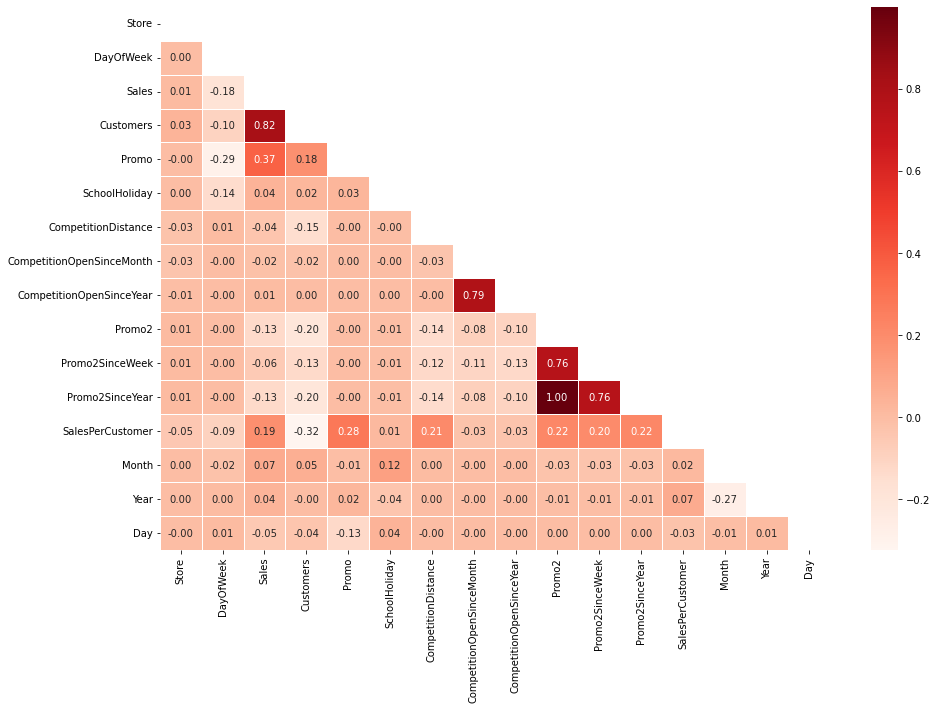

In [52]:
utl.plot_correlation_heatmap(df_correlation)

**Interpretation:**

- Customers and Sales: A strong positive correlation of 0.82 confirms that the number of customers is closely related to sales.
- Sales per Customer and Promo: A positive correlation of 0.28 suggests that running promotions increases sales per customer.
- Sales per Customer and Competition Distance: A positive correlation of 0.21 indicates that greater competition distance is associated with higher sales per customer.
- Promo2 and Sales per Customer: A correlation of 0.22 suggests that continuous promotions influence buying patterns and lead to increased sales per customer.
- StoreType and Sales per Customer: A correlation of 0.44 highlights the significant role of StoreType in determining sales per customer.

Overall, these correlations provide valuable insights into the relationships between variables and sales per customer in the dataset. These findings will be taken into consideration during the feature selection process.

______

### Seasonality

In this section, we will define the patterns associated with time series, namely:
- the trend, 
- seasonality, and 
- cycles. 
These patterns are examined and identified through visual inspection and statistical techniques.

By examining these components, we can gain insights into the underlying patterns and dynamics of the time series data.

<sup> * </sup> <font size ="2">To obtain accurate information about time series components and minimize bias, the analysis was conducted using the original data. </font>

#### Analysis based on original data:

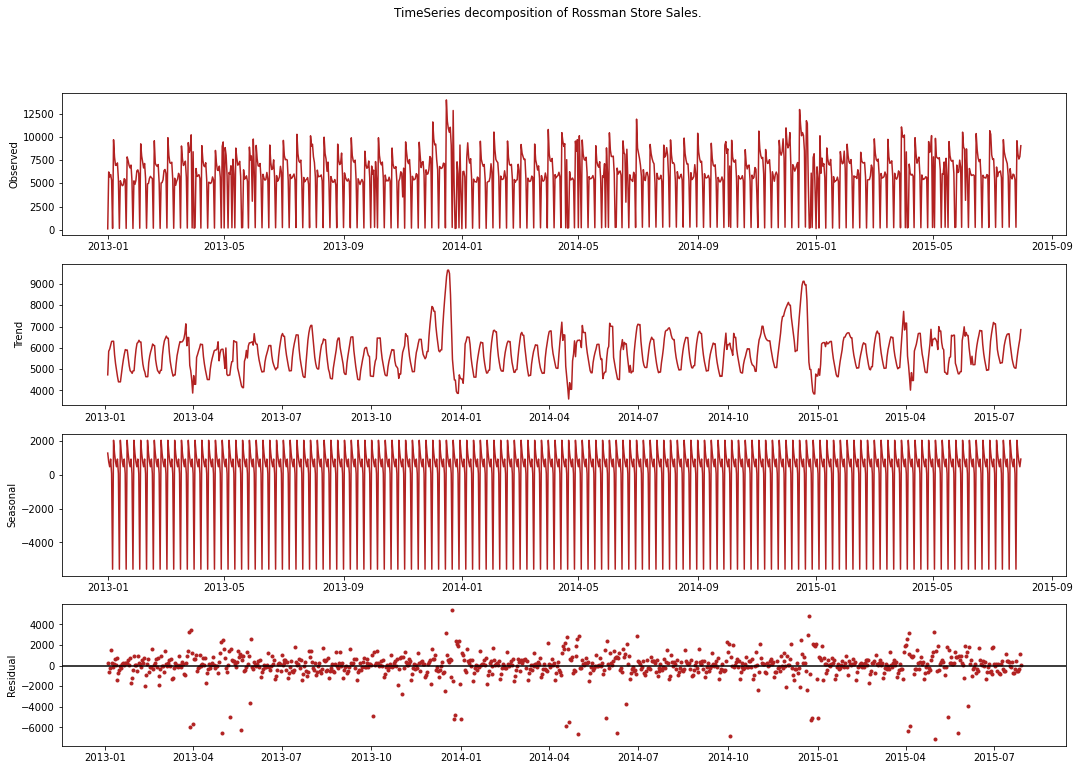

In [53]:
utl.custom_seasonal_decompose(df_sales, title="TimeSeries decomposition of Rossman Store Sales.", set_date_index=True)

**Findings**:

Based on visual inspection of the graphs above, it is inconclusive whether a trend exists; however, there is a strong indication of seasonality.

#### Moving average plot

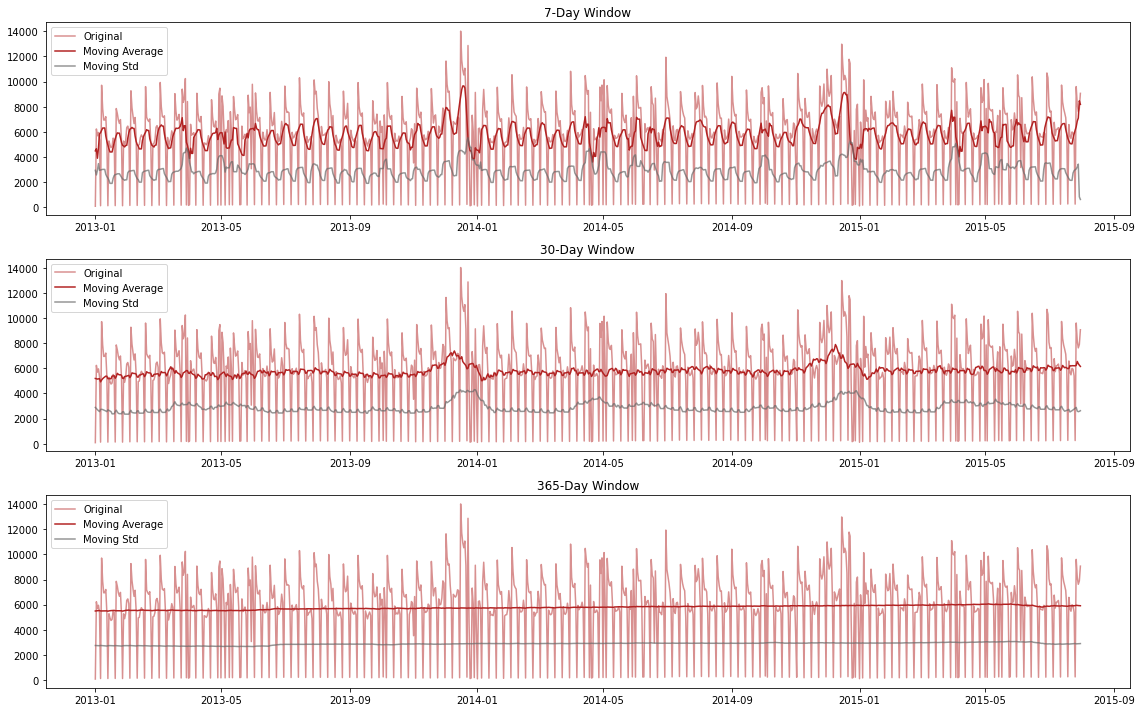

In [54]:
utl.rolling_mean_analysis(df_sales)

**Comment:**

Based on a careful visual analysis of the presented graphs, our previous suspicion is reinforced, indicating the presence of seasonality (with a peak around December) and a lack of evident trend, suggesting that the time series is likely stationary.

#### Inspection of ACF:

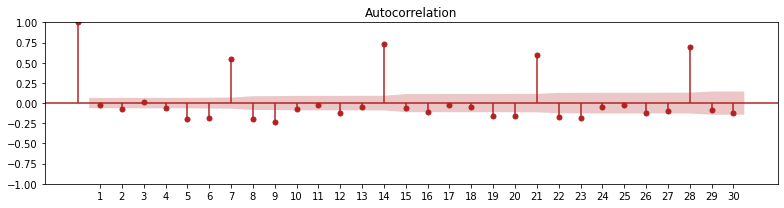

In [55]:
utl.custom_plot_acf(df_sales, 'Sales')

**Comment:**

Based on a visual assessment, there appears to be a weak trend, while the ACF correlogram indicates that the series is non-stationary primarily due to seasonality rather than a trend. The presence of a trend may have minimal significance.

To further investigate, we will conduct unit root tests to determine the significance level of the trend.

#### Stationary test

In [56]:
help(utl.custom_test_stationarity)

Help on function custom_test_stationarity in module utils:

custom_test_stationarity(df: pandas.core.frame.DataFrame, col_date: str = 'Date', column: str = 'Sales', resample: str = 'D', full_results: bool = True, make_diff: bool = False, num_diff: int = 1, set_date_index: bool = True, return_diffed_df=False)
    Description:
    
    Perform stationarity tests on a time series using the Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests.
    
    To ensure the stationarity of the series, it is recommended to apply both tests.
    
    Possible outcomes of applying these stationary tests are as follows:
    
    Case 1: Both tests conclude that the series is not stationary - The series is not stationary
    Case 2: Both tests conclude that the series is stationary - The series is stationary
    Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. 
            Trend needs to be removed to make series strict

In [57]:
utl.custom_test_stationarity(df_sales, full_results=False)

Results of Stationarity Tests: 

ADF p-value:  0.0000009870
KPSS p-value: 0.0171483677 

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


In [58]:
df_diffed = utl.custom_test_stationarity(df_sales, full_results=False, make_diff=True, return_diffed_df= True)

Results of Stationarity Tests: 

ADF p-value:  0.0000000000
KPSS p-value: 0.1000000000 

Case 2: Both tests conclude that the series is stationary - The series is stationary


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


#### Analysis based on stationary time series:

In the preceding section, the trend was extracted through the utilization of time series differencing techniques. Moving forward, the objective will be to assess the presence of seasonality.

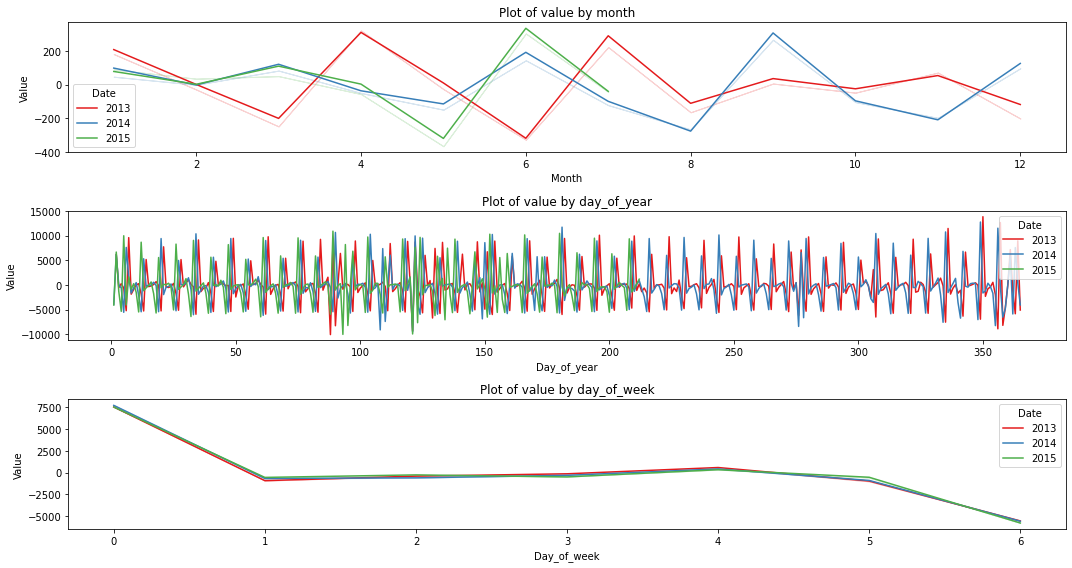

In [59]:
variables = ['month', 'day_of_year', 'day_of_week']

plt.figure(figsize=(15, 8))

# Iterate over variables and create subplots
for i, variable in enumerate(variables):
    plt.subplot(len(variables), 1, i+1)
    
    # Determine x-axis values based on the variable
    x_values = df_diffed.index.month if variable == 'month' else \
               (df_diffed.index.dayofyear if variable == 'day_of_year' else \
                df_diffed.index.dayofweek)
    
    # Plot the line graph with hue as the year
    sns.lineplot(x=x_values, y=df_diffed, hue=df_diffed.index.year, data=df_diffed, ci=False, palette='Set1')
    
    plt.xlabel(variable.capitalize())
    plt.ylabel('Value')
    plt.title(f'Plot of value by {variable}')

plt.tight_layout()
plt.show()

**Comments:**
- Upon examining the middle chart, suggests the presence of additive seasonality without a noticeable trend. It is likely that the data exhibits a weekly or semi-weekly seasonality, as indicated by the double spikes observed.
- Notably, the demand shows a distinct pattern within a week, with the highest levels observed on Mondays.
- As most shops tend to be closed on Sundays, the data reveals the lowest demand on Sundays. This observation is further supported by the bottom charts.

In order to determine the most useful seasonality period more objectively, it would be beneficial to analyze the correlogram and periodogram, which provide additional insights into the periodic patterns and potential frequencies present in the data.

#### Inspection of ACF (stationary TS):

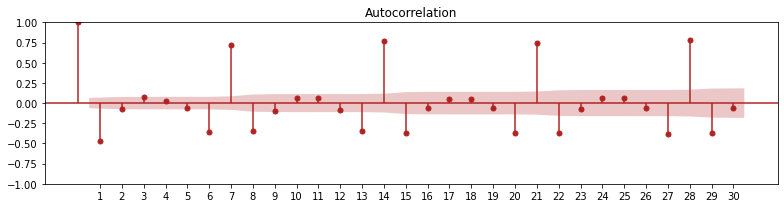

In [60]:
utl.custom_plot_acf(df_diffed, 'Sales', set_date_index=False, resample_df=False)

**Findings:**
- The autocorrelation plot, with a lag of 30 periods, reveals negative spikes at lags 1 and 6, and a positive spike at lag 7.
- Mondays exhibit significant increases in sales following significant decreases on Sundays, while Fridays show relatively mild increases.
- These observations suggest the presence of weekly seasonality in the data.

The findings from the autocorrelation (AFC) correlogram align with the patterns observed in the seasonal plots discussed earlier.

/var/folders/v7/f39x22454kq9517cdvj0wcnc0000gn/T/ipykernel_68403/4202131463.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax1 = utl.custom_plot_periodogram(df_sales.groupby('Date')['Sales'].agg('sum'), fig_size=(12,4))
/var/folders/v7/f39x22454kq9517cdvj0wcnc0000gn/T/ipykernel_68403/4202131463.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax2 = utl.custom_plot_periodogram(df_diffed, fig_size=(12,4))


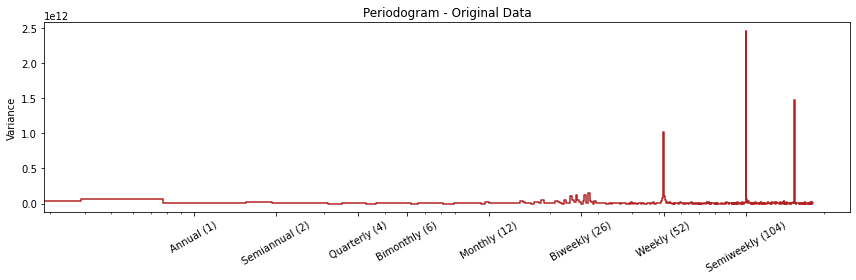

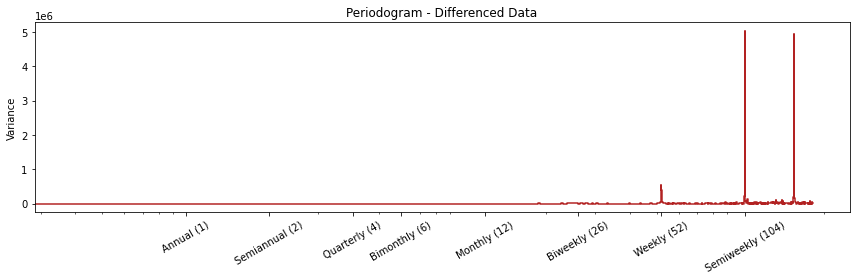

In [61]:
ax1 = utl.custom_plot_periodogram(df_sales.groupby('Date')['Sales'].agg('sum'), fig_size=(12,4))
ax1.set_title("Periodogram - Original Data")
ax2 = utl.custom_plot_periodogram(df_diffed, fig_size=(12,4))
ax2.set_title("Periodogram - Differenced Data")
plt.show()

**The periodogram analysis provides several interesting findings:**

- The periodogram analysis confirms the existence of weekly seasonality, which aligns with the findings from the autocorrelation function (ACF) correlogram.
- The evidence of a semi-weekly season is more prominent than a weekly season based on the periodogram results.
- Considering the business days, this observation is logical since most shops are closed on Sundays. The correlogram suggests that people tend to engage in shopping activities on the first day of the week and/or the day preceding the weekend.

## Conclusion from EDA:

At this stage, we have acquired a comprehensive understanding of the distributions, statistical properties, and interrelationships among variables. The subsequent phase involves determining the appropriate variables to be used as inputs for training the machine learinig models, as we proceed with the modeling aspect of the project.

General fingings:

a) Stores:

- StoreType A emerges as the most prosperous in terms of sales and customer traffic, suggesting its high popularity among consumers. Conversely, StoreType D demonstrates the highest "Sale per Customer" metric, implying that customers tend to make larger purchases in these establishments. It is reasonable to hypothesize that StoreType D stores are predominantly located in rural areas, where customers prefer infrequent yet substantial shopping trips.

- StoreType B exhibits a lower "Sale per Customer" value, indicating a prevalence of smaller-scale purchases made by customers. This observation aligns with the urban designation assigned to this store type, implying its accessibility and convenience for customers engaging in occasional shopping throughout the week.

b) Promotion:

- Moreover, our analysis reveals that customers show a heightened propensity for making purchases on Mondays when a single promotion (Promo) is active, as well as on Sundays when no promotions are in effect (both Promo and Promo1 equal to 0).

- Interestingly, the presence of Promo2 alone does not exhibit a significant correlation with changes in sales volume.

c) CompetitionDistance:

- Surprisingly, we found no discernible relationship between the average sales per customer and the distance to the nearest competitor.

d) Seasonality:

- Our comprehensive analysis of seasonality further corroborates the existence of weekly seasonality, which aligns with the findings derived from incl. the autocorrelation function (ACF) correlogram.

## Modeling Section Is Presented in a Separate Notebook